In [16]:
# 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import CategoricalNB

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import mutual_info_classif
from collections import Counter

In [2]:
# 2. Load Dataset
df = pd.read_excel('StudentPerformanceFactors.xlsx')
print(df.shape)
print(df.info())
print(df.describe())
print(df['Exam_Score'].value_counts())

(6608, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6608 entries, 0 to 6607
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Hours_Studied               6607 non-null   float64
 1   Attendance                  6607 non-null   float64
 2   Parental_Involvement        6607 non-null   object 
 3   Access_to_Resources         6607 non-null   object 
 4   Extracurricular_Activities  6607 non-null   object 
 5   Sleep_Hours                 6607 non-null   float64
 6   Previous_Scores             6608 non-null   int64  
 7   Motivation_Level            6607 non-null   object 
 8   Internet_Access             6607 non-null   object 
 9   Tutoring_Sessions           6607 non-null   float64
 10  Family_Income               6607 non-null   object 
 11  Teacher_Quality             6607 non-null   object 
 12  School_Type                 6607 non-null   object 
 13  Peer_Influence        

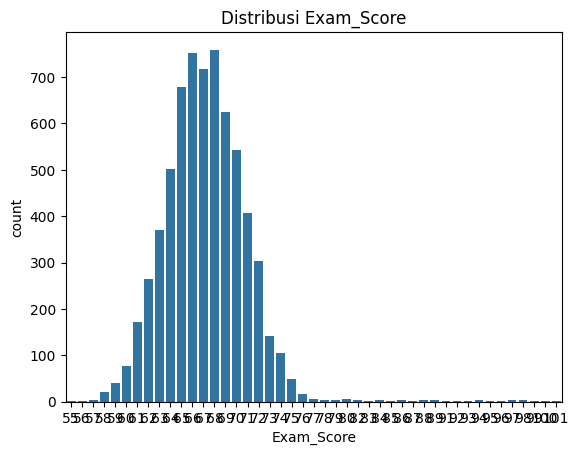

In [3]:
# 3. Exploratory Data Analysis (EDA)
## 3.1 Distribusi variabel target
sns.countplot(x='Exam_Score', data=df)
plt.title('Distribusi Exam_Score')
plt.show()



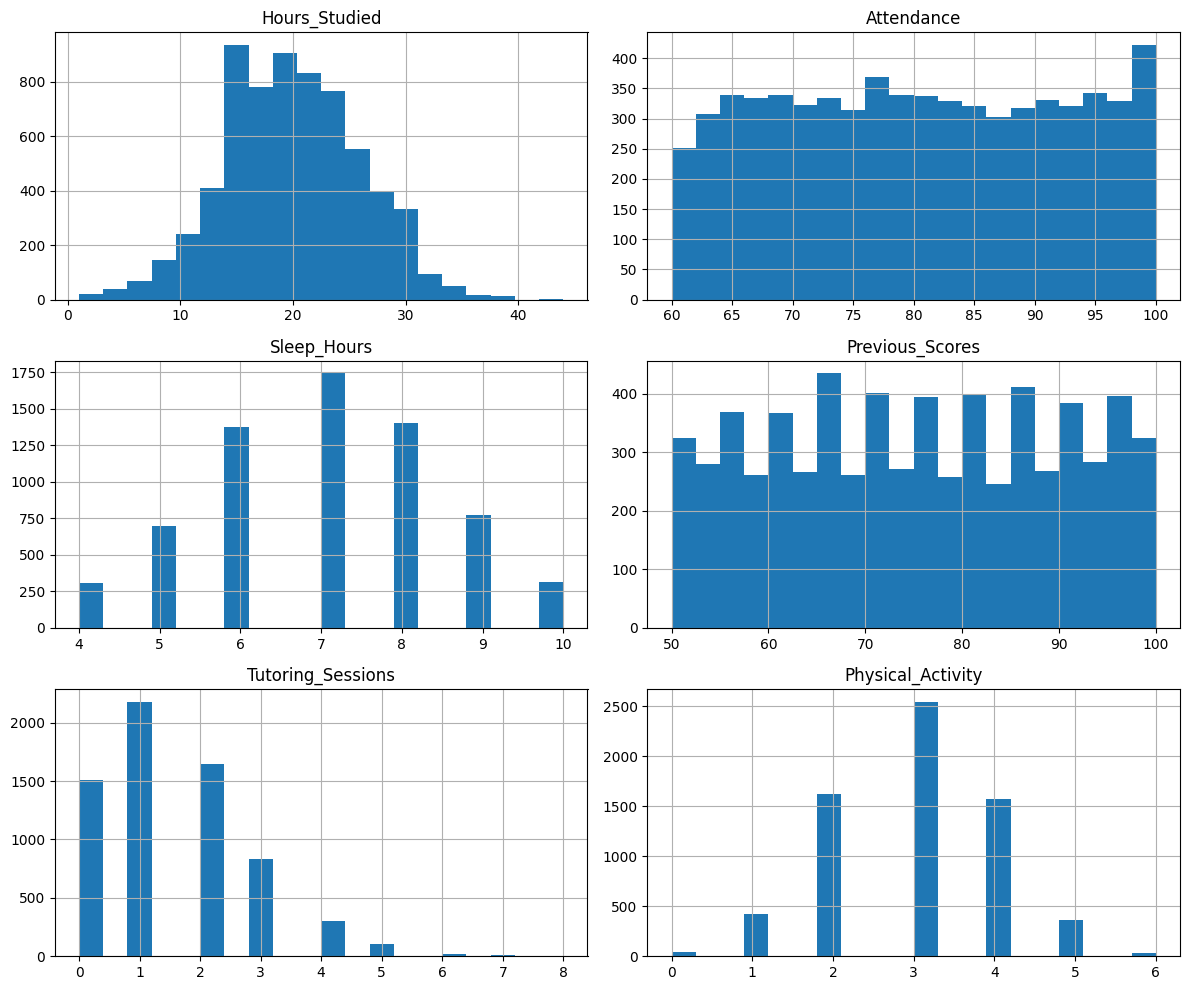

In [4]:
## 3.2 Distribusi variabel numerik
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('Exam_Score')
df[num_cols].hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.show()

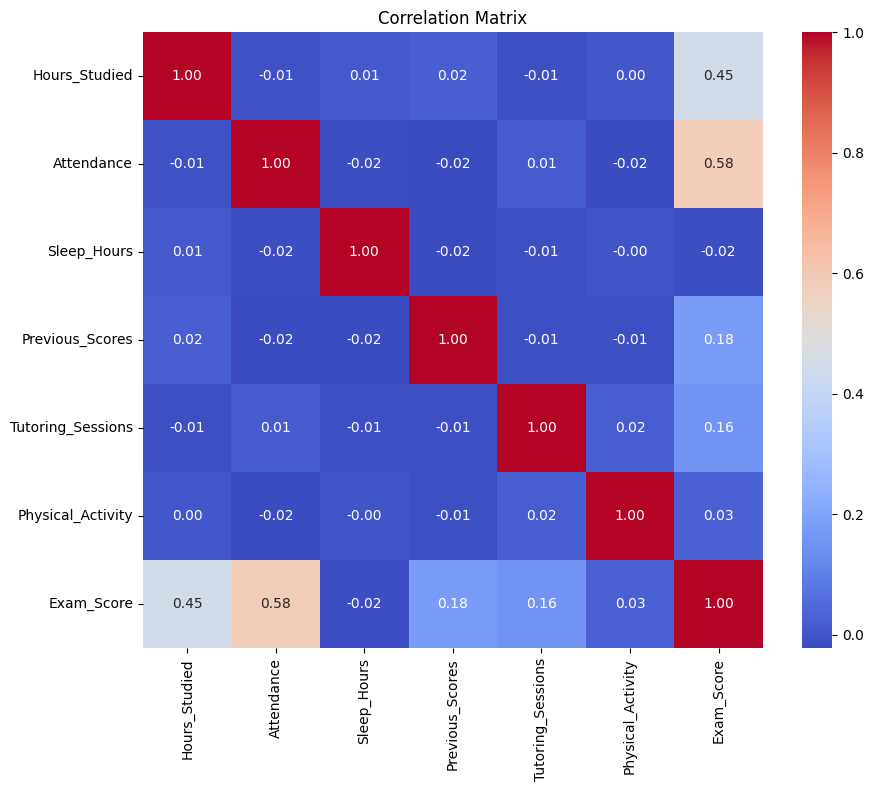

In [5]:
## 3.3 Correlation matrix
corr = df[num_cols + ['Exam_Score']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

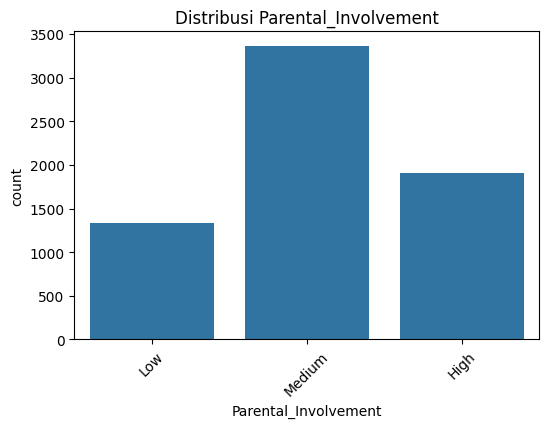

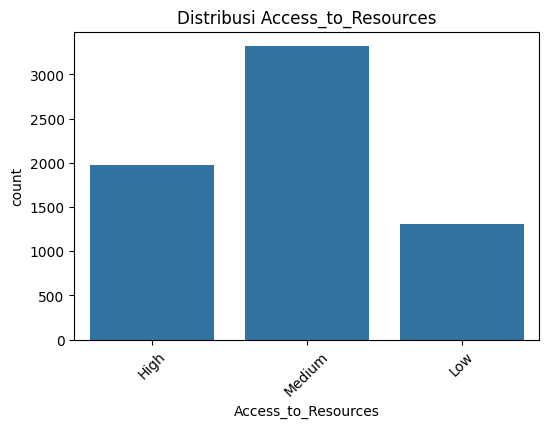

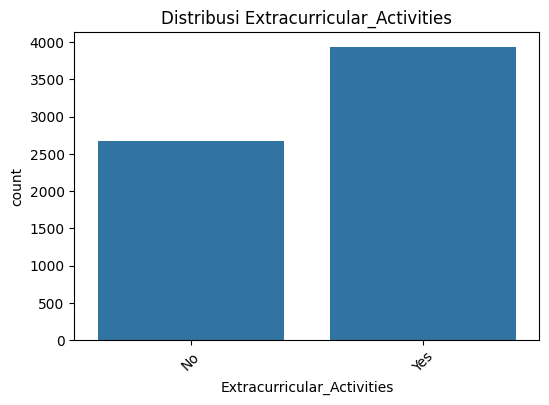

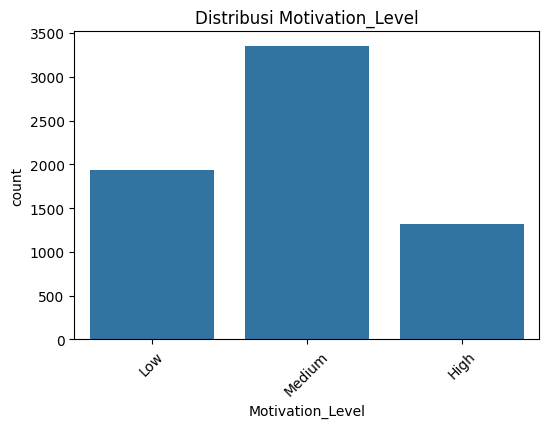

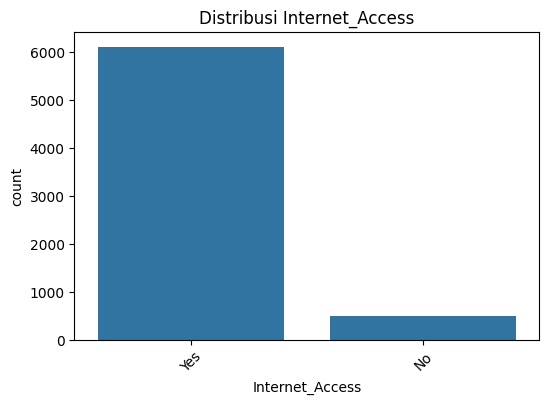

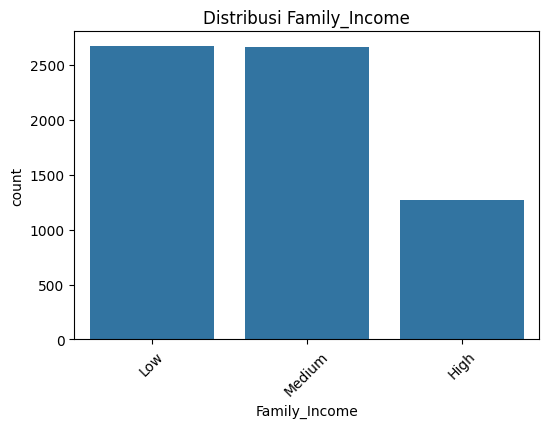

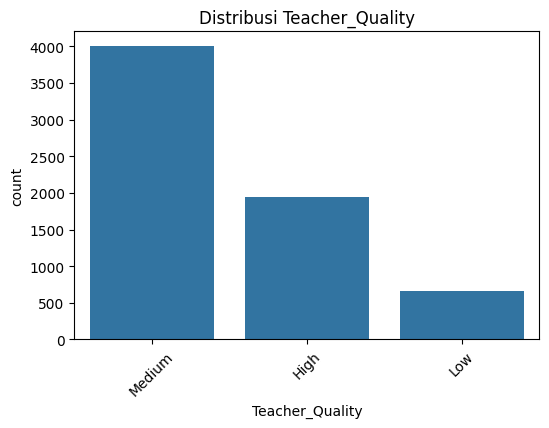

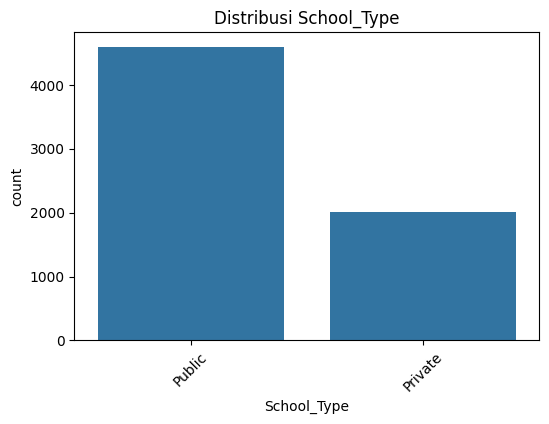

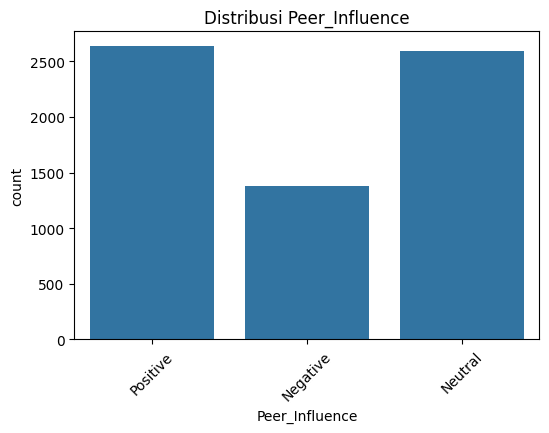

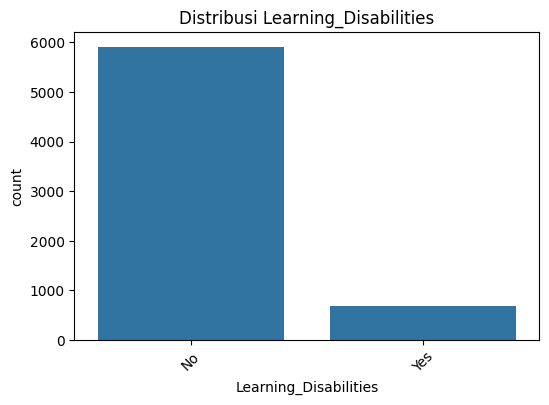

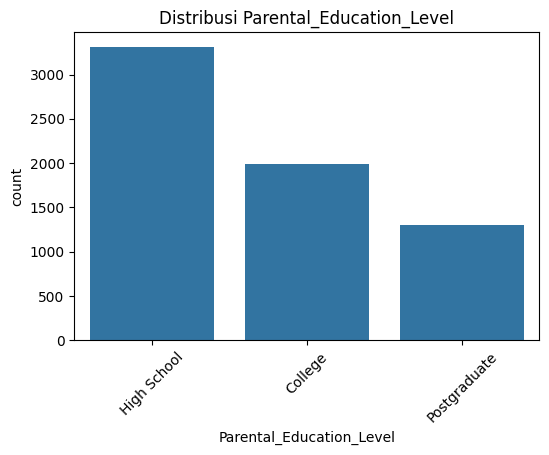

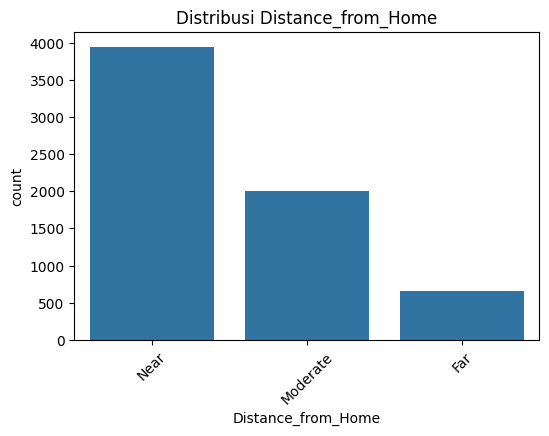

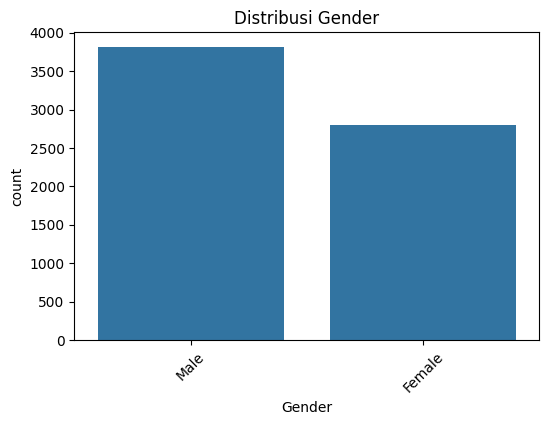

In [6]:
## 3.4 Variabel kategori
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribusi {col}')
    plt.xticks(rotation=45)
    plt.show()

In [7]:
# 4. Data Pre-processing
## 4.1 Missing values
print(df.isna().sum())
# Imputasi sederhana untuk kolom kategori
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Hours_Studied                 1
Attendance                    1
Parental_Involvement          1
Access_to_Resources           1
Extracurricular_Activities    1
Sleep_Hours                   1
Previous_Scores               0
Motivation_Level              1
Internet_Access               1
Tutoring_Sessions             1
Family_Income                 1
Teacher_Quality               1
School_Type                   1
Peer_Influence                1
Physical_Activity             0
Learning_Disabilities         1
Parental_Education_Level      1
Distance_from_Home            1
Gender                        1
Exam_Score                    0
dtype: int64


In [8]:
## 4.2 Encoding
# Untuk kolom ordinal 
ordinal_cols = ['Parental_Education_Level','Motivation_Level','Teacher_Quality']
ord_enc = OrdinalEncoder()
df[ordinal_cols] = ord_enc.fit_transform(df[ordinal_cols])

# Untuk kolom kategorikal lainnya
for col in [c for c in cat_cols if c not in ordinal_cols]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [9]:
## 4.3 Scaling numerik
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [11]:
# 5. Train-Test Split
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [21]:
class_counts = Counter(y_train)
print("Distribusi kelas sebelum filtering:", class_counts)

# Hapus kelas yang jumlahnya < 2
rare_classes = [cls for cls, count in class_counts.items() if count < 2]
if rare_classes:
    print("Menghapus kelas terlalu kecil:", rare_classes)
    mask = ~y_train.isin(rare_classes)
    X_train = X_train[mask]
    y_train = y_train[mask]

# Jalankan SMOTE setelah filtering

sm = SMOTE(random_state=42, k_neighbors=1)
X_over, y_over = sm.fit_resample(X_train, y_train)
print("Distribusi kelas sesudah SMOTE:", Counter(y_over))

Distribusi kelas sebelum filtering: Counter({68: 616, 66: 603, 67: 588, 65: 540, 69: 508, 70: 426, 64: 401, 71: 323, 63: 290, 72: 238, 62: 200, 61: 135, 73: 107, 74: 89, 60: 65, 75: 35, 59: 32, 58: 18, 76: 16, 78: 4, 82: 4, 77: 4, 80: 4, 86: 4, 88: 3, 84: 3, 94: 3, 97: 3, 87: 2, 92: 2, 79: 2, 93: 2, 57: 2, 95: 2, 99: 2})
Distribusi kelas sesudah SMOTE: Counter({71: 616, 74: 616, 69: 616, 66: 616, 67: 616, 72: 616, 70: 616, 65: 616, 64: 616, 68: 616, 63: 616, 61: 616, 59: 616, 73: 616, 62: 616, 78: 616, 88: 616, 75: 616, 76: 616, 82: 616, 87: 616, 60: 616, 58: 616, 92: 616, 79: 616, 93: 616, 77: 616, 57: 616, 84: 616, 80: 616, 94: 616, 95: 616, 99: 616, 86: 616, 97: 616})


In [19]:
## 6.2 Undersampling (optional)
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [ ]:
## 6.3 Hybrid SMOTE + ENN
sm_enn = SMOTEENN(random_state=42)
X_hybrid, y_hybrid = sm_enn.fit_resample(X_train, y_train)

In [22]:
# 7. Modeling dengan Naive Bayes
models = {
    'NaiveBayes_original': CategoricalNB(),
    'NaiveBayes_over': CategoricalNB(),
    'NaiveBayes_hybrid': CategoricalNB()
}


In [23]:
# Fit original
models['NaiveBayes_original'].fit(X_train, y_train)
y_pred_orig = models['NaiveBayes_original'].predict(X_test)
print("=== Original ===")
print("Accuracy:", accuracy_score(y_test, y_pred_orig))
print(classification_report(y_test, y_pred_orig))

=== Original ===
Accuracy: 0.10816944024205749
              precision    recall  f1-score   support

          55       0.00      0.00      0.00         1
          57       0.00      0.00      0.00         2
          58       0.00      0.00      0.00         4
          59       0.00      0.00      0.00         8
          60       0.00      0.00      0.00        12
          61       1.00      0.03      0.05        36
          62       0.33      0.03      0.06        64
          63       0.13      0.02      0.04        81
          64       0.09      0.02      0.03       100
          65       0.09      0.14      0.11       139
          66       0.13      0.26      0.18       148
          67       0.11      0.21      0.15       129
          68       0.09      0.20      0.13       143
          69       0.11      0.10      0.11       116
          70       0.07      0.04      0.05       116
          71       0.08      0.04      0.05        85
          72       0.17      0.06 

c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [24]:
# Fit oversampled
models['NaiveBayes_over'].fit(X_over, y_over)
y_pred_over = models['NaiveBayes_over'].predict(X_test)
print("=== Oversampled ===")
print("Accuracy:", accuracy_score(y_test, y_pred_over))
print(classification_report(y_test, y_pred_over))

=== Oversampled ===
Accuracy: 0.06127080181543117
              precision    recall  f1-score   support

          55       0.00      0.00      0.00         1
          57       0.00      0.00      0.00         2
          58       0.02      0.25      0.03         4
          59       0.02      0.12      0.04         8
          60       0.02      0.08      0.03        12
          61       0.11      0.25      0.15        36
          62       0.10      0.09      0.10        64
          63       0.06      0.04      0.04        81
          64       0.19      0.07      0.10       100
          65       0.09      0.04      0.05       139
          66       0.07      0.02      0.03       148
          67       0.14      0.12      0.13       129
          68       0.09      0.02      0.03       143
          69       0.12      0.03      0.05       116
          70       0.12      0.03      0.04       116
          71       0.09      0.09      0.09        85
          72       0.09      0.

c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [27]:
# Fit hybrid
models['NaiveBayes_hybrid'].fit(X_hybrid, y_hybrid)
y_pred_hybrid = models['NaiveBayes_hybrid'].predict(X_test)
print("=== Hybrid SMOTE+ENN ===")
print("Accuracy:", accuracy_score(y_test, y_pred_hybrid))
print(classification_report(y_test, y_pred_hybrid))

NameError: name 'X_hybrid' is not defined

In [25]:
# 8. Cross-Validation (optional)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(models['NaiveBayes_over'], X_over, y_over, cv=cv, scoring='accuracy')
print("CV Mean Accuracy (oversampled NB):", scores.mean())

CV Mean Accuracy (oversampled NB): nan


c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "c:\Users\surya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response

In [26]:
mi = mutual_info_classif(X, y, discrete_features=True)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Info Feature Importance:")
print(mi_series)

ValueError: Input X contains NaN.